In [1]:
import os
import pydicom
%pylab inline
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob



Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_data(data,cmaps,label_names=None):
    data_shape = np.array(data).shape
    numImageTypes = data_shape[0]
    numImageSets = data_shape[1]
    print(numImageTypes,numImageSets)
    fig = plt.figure(figsize=(3*numImageTypes,3*numImageSets))
    for i in range(numImageSets):
        for j in range(numImageTypes):
            ax = plt.subplot(numImageSets, numImageTypes,i*numImageTypes + j+1)
            if not label_names==None:
                ax.set_title(label_names[j])
            plt.axis('off')
            img = plt.imshow(data[j][i])
            img.set_cmap(cmaps[j])
    plt.show()

def plot_prepared_data(prepared_data,labels,label_names=None):
    cmaps = ['gray','gist_ncar']
    data = [prepared_data[0][:,:,:,0], one_hot_decoding(prepared_data[1],labels)]
    data_shape = np.array(data).shape
    numImageTypes = data_shape[0]
    numImageSets = data_shape[1]
    print(numImageTypes,numImageSets)
    fig = plt.figure(figsize=(3*numImageTypes,3*numImageSets))
    for i in range(numImageSets):
        for j in range(numImageTypes):
            ax = plt.subplot(numImageSets, numImageTypes,i*numImageTypes + j+1)
            if not label_names==None:
                ax.set_title(label_names[j])
            plt.axis('off')
            img = plt.imshow(data[j][i])
            img.set_cmap(cmaps[j])
    plt.show()

In [3]:

from tensorflow.keras import utils
def fix_labels2(label_images,labels):
    encoded = []
    numLabels = len(labels)
    for img in label_images:
        img2 = numpy.zeros_like(img)
        for i,label in enumerate(labels):
            img2 = np.where(img==label, i+1, img2)
        encoded.append(img2)
    return encoded
def fix_labels(img,labels):
    img2 = numpy.zeros_like(img)
    for i,label in enumerate(labels):
        img2 = np.where(img==label, i+1, img2)        
    return img2
        
def one_hot_encoding(label_images,numLabels):
    encoded = []
    for img in label_images:
        original_shape = img.shape
        #print(original_shape)
        #print(numLabels)
        img2= utils.to_categorical(img.flatten(), numLabels)
        img2 = np.reshape(img2, (original_shape[0],original_shape[1],numLabels))
        encoded.append(img2)
        #print(numLabels,img2.shape)
    return encoded

        
def one_hot_decoding(encodings,labels):
    decoded = []
    for img in encodings:
        if (len(img.shape)!=3):
            print("ERROR: wrong shape")
        original_shape = (img.shape[0],img.shape[1])
        img2 = numpy.zeros(original_shape)
        
        #print(original_shape)
        for i, label in enumerate(labels):
            img2 += np.array(img)[:,:,i+1]*label
        decoded.append(img2)
    return decoded

In [4]:
#from tensorflow.keras
from tensorflow import keras
import tensorflow as tf
from tensorflow.python.keras import backend as k
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPool2D,concatenate, add
#from tensorflow.keras.layers.core import Lambda, RepeatVector, Reshape
#from tensorflow.keras.layers.convolutional import Conv2D, Conv2DTranspose
#from tensorflow.keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
#from tensorflow.keras.layers.merge import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=2, padding=padding)#strides=strides,

def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(kernel_size)


def conv2d_block(
    inputs, 
    use_batch_norm=True, 
    dropout=0.3, 
    filters=16, 
    kernel_size=(3,3), 
    activation='relu', 
    kernel_initializer='he_normal', 
    padding='same'):
    
    c = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding) (inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    #if dropout > 0.0:
    c = Dropout(dropout)(c)
    c = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding) (c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c

def normal_unet(
    inputs,
    num_classes=1,
    num_channels=1,
    use_batch_norm=True, 
    upsample_mode='deconv', #'simple', #  'deconv' or 
    use_dropout_on_upsampling=False, 
    dropout=0.15, 
    dropout_change_per_layer=0.0,
    filters=16,
    num_layers=4,
    output_activation='softmax'): # 'sigmoid' or 'softmax'
    print("--------create unet")
    if upsample_mode=='deconv':
        upsample=upsample_conv
    else:
        upsample=upsample_simple
    keras.backend.set_image_data_format('channels_last')

    # Build U-Net model
    #inputs = Input( shape=(num_channels,) +tuple(input_shape), name="input") #
    x = inputs   

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(inputs=x, filters=filters, use_batch_norm=use_batch_norm, dropout=dropout)
        print(" -v- ",filters)
        down_layers.append(x)
        x = MaxPooling2D((2, 2)) (x)
        dropout += dropout_change_per_layer
        filters = filters*2 # double the number of filters with each layer

    x = conv2d_block(inputs=x, filters=filters, use_batch_norm=use_batch_norm, dropout=dropout)
    print(" -+- ",filters)
    print(down_layers)

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):        
        filters //= 2 # decreasing number of filters with each layer 
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2,2), strides=(2, 2), padding='same') (x)#(2, 2)
        print(" -^- ",filters)
        x = tf.keras.layers.concatenate([x, conv],axis=3)
        x = conv2d_block(inputs=x, filters=filters, use_batch_norm=use_batch_norm, dropout=dropout)

    outputs = Conv2D(num_classes, (1, 1),  activation='softmax', name="output") (x)    

    model = Model(inputs=[inputs], outputs=[outputs])
    print("num_classes",num_classes)
    
    #print(model.summary())
    return model

In [5]:
def read_data(path):
    #print(path)
    train_gt = glob.glob(path + "/*.cso.dcm")
    train_T1 = [ s.replace(".cso", "_T1") for s in train_gt]
    train_T2 = [ s.replace(".cso", "_T2") for s in train_gt]
    train_T2s = [ s.replace(".cso", "_T2s") for s in train_gt]
    train_PD = [ s.replace(".cso", "_PD") for s in train_gt]
    #print(train_gt)
    gts = []
    t1s = []
    t2s = []
    t2ss = []
    pds = []
    for s in train_gt:
        ds = pydicom.dcmread(s) 
        gts.append(ds.pixel_array)
    for s in train_T1:
        ds = pydicom.dcmread(s) 
        t1s.append(ds.pixel_array)
    for s in train_T2:
        ds = pydicom.dcmread(s) 
        t2s.append(ds.pixel_array)
    for s in train_T2s:
        ds = pydicom.dcmread(s) 
        t2ss.append(ds.pixel_array)
    for s in train_PD:
        ds = pydicom.dcmread(s) 
        pds.append(ds.pixel_array)
    
    return t1s,t2s,t2ss,pds,gts

def combine_contrasts(contrasts):
    contrasts = [np.array(c) for c in contrasts]
    #print("c",contrasts[1].shape)
    combined_contrasts = np.stack(contrasts,axis=3)
    #print("d",combined_contrasts.shape)
    return combined_contrasts

def prepare_data(path,labels):
    print('Labels: '+ str(labels))
    t1s,t2s,t2ss,pds,gts = read_data(path)
    #print("gts:",np.unique(gts[0]),np.unique(gts[1]))
    data_x = combine_contrasts([t1s,t2s,t2ss,pds])
    #print("e",train_x.shape,len(labels)+1)
    data_y = np.array(one_hot_encoding(fix_labels2(gts,labels),len(labels)+1))#labels,15))#
    return data_x,data_y

In [6]:
allLabels = {"lumen": 14, 
             "intima":  1 , 
             "media":  2 , 
             "AtheromatousCore":  4 , 
             "FibrousTissue":  3 , 
             "calcification": 13 ,
             "WhiteThrombus": 6 ,
             "RedThrombus":  7 ,
             "microvessels":  11 ,
             "hemorrhage":  12 ,
             "unknown":  8 ,
             "inflammation":  10 ,
             "fibrin+hemorrhage":  9 ,
             "atheromatous+hemorrhage":  5 ,
             "background": 0}
id_to_label = {v: k for k, v in allLabels.items()}

labels_to_keep = [1,2,5,8,13,14]


In [7]:
path = '../data/raw'
path_train = path + "/train"
path_eval  = path + "/eval"
path_test  = path + "/test"

## Data Preparation

In [8]:
train_x, train_y = prepare_data(path_train,labels_to_keep)
print('Training data:')
print("x shape:",train_x[0].shape)
print("y shape:",train_y[0].shape)
print('-------------------------')



eval_x, eval_y = prepare_data(path_eval,labels_to_keep)
print('Evaluation data:')
print("x shape:",eval_x[0].shape)
print("y shape:",eval_y[0].shape)
print('-------------------------')

print('Test data: ')
test_x, test_y = prepare_data(path_test,labels_to_keep)
print("x shape:",train_x[0].shape)
print("y shape:",train_y[0].shape)

Labels: [1, 2, 5, 8, 13, 14]
Training data:
x shape: (512, 512, 4)
y shape: (512, 512, 7)
-------------------------
Labels: [1, 2, 5, 8, 13, 14]
Evaluation data:
x shape: (512, 512, 4)
y shape: (512, 512, 7)
-------------------------
Test data: 
Labels: [1, 2, 5, 8, 13, 14]
x shape: (512, 512, 4)
y shape: (512, 512, 7)


## Data Augmentation

In [9]:
seed = 1

# Creating the training Image and Mask generator
image_datagen = ImageDataGenerator(rotation_range=30, horizontal_flip=True, vertical_flip=True)
mask_datagen = ImageDataGenerator(rotation_range=30, horizontal_flip=True, vertical_flip=True)

# keep the same seed for image and mask generators so that they fit together
image_datagen.fit(train_x, augment=True, seed = seed)
mask_datagen.fit(train_y, augment=True, seed = seed)

x = image_datagen.flow(train_x, batch_size=2,shuffle=True, seed=seed)
y = image_datagen.flow(train_y, batch_size=2,shuffle=True, seed=seed)

/home/amos/anaconda3/envs/thesis/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:923: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (49, 512, 512, 7) (7 channels).
  ' channels).')
/home/amos/anaconda3/envs/thesis/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (49, 512, 512, 7) (7 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [10]:
# creating the validation Image and Mask generator
image_datagen_val = ImageDataGenerator()
mask_datagen_val = ImageDataGenerator()

image_datagen_val.fit(eval_x, augment=True, seed = seed)
mask_datagen_val.fit(eval_y, augment=True, seed = seed)

x_val = image_datagen.flow(eval_x, batch_size=2,shuffle=True, seed=seed)
y_val = image_datagen.flow(eval_y, batch_size=2,shuffle=True, seed=seed)

/home/amos/anaconda3/envs/thesis/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:923: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (11, 512, 512, 7) (7 channels).
  ' channels).')
/home/amos/anaconda3/envs/thesis/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (11, 512, 512, 7) (7 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [11]:
# creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [12]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        k.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return k.mean(k.stack(prec), axis=0)



def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = k.sum(k.round(k.clip(y_true * y_pred, 0, 1)))
    c2 = k.sum(k.round(k.clip(y_pred, 0, 1)))
    c3 = k.sum(k.round(k.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score



def recall(y_true, y_pred):
    y_true = k.ones_like(y_true) 
    true_positives = k.sum(k.round(k.clip(y_true * y_pred, 0, 1)))
    all_positives = k.sum(k.round(k.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + k.epsilon())
    return recall



def precision(y_true, y_pred):
    y_true = k.ones_like(y_true) 
    true_positives = k.sum(k.round(k.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = k.sum(k.round(k.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + k.epsilon())
    return precision


def Mean_IOU_tensorflow_1(y_true, y_pred):
    nb_classes = k.int_shape(y_pred)[-1]
    iou = []
    true_pixels = k.argmax(y_true, axis=-1)
    pred_pixels = k.argmax(y_pred, axis=-1)
    void_labels = k.equal(k.sum(y_true, axis=-1), 0)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = k.equal(true_pixels, i) & ~void_labels
        pred_labels = k.equal(pred_pixels, i) & ~void_labels
        inter = tf.to_int32(true_labels & pred_labels)
        union = tf.to_int32(true_labels | pred_labels)
        legal_batches = k.sum(tf.to_int32(true_labels), axis=1)>0
        ious = k.sum(inter, axis=1)/k.sum(union, axis=1)
        iou.append(k.mean(tf.gather(ious, indices=tf.where(legal_batches)))) # returns average IoU of the same objects
    iou = tf.stack(iou)
    legal_labels = ~tf.debugging.is_nan(iou)
    iou = tf.gather(iou, indices=tf.where(legal_labels))
    return k.mean(iou)


def jaccard_coef(y_true, y_pred):
    intersection = k.sum(y_true * y_pred)
    union = k.sum(y_true + y_pred)
    jac = (intersection + 1.) / (union - intersection + 1.)
    return k.mean(jac)


In [13]:
input_img = tf.keras.Input(train_x[0].shape, name='img')
model = normal_unet(input_img, filters=32, dropout=0.15,num_classes=len(labels_to_keep)+1,num_channels=4,num_layers=4)
model.summary()

--------create unet
 -v-  32
 -v-  64
 -v-  128
 -v-  256
 -+-  512
[<tf.Tensor 'batch_normalization_1/cond/Merge:0' shape=(?, 512, 512, 32) dtype=float32>, <tf.Tensor 'batch_normalization_3/cond/Merge:0' shape=(?, 256, 256, 64) dtype=float32>, <tf.Tensor 'batch_normalization_5/cond/Merge:0' shape=(?, 128, 128, 128) dtype=float32>, <tf.Tensor 'batch_normalization_7/cond/Merge:0' shape=(?, 64, 64, 256) dtype=float32>]
 -^-  256
 -^-  128
 -^-  64
 -^-  32
num_classes 7
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 1184        img[0][0]                        
________________________________

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[mean_iou, f1_score, jaccard_coef, Mean_IOU_tensorflow_1])

In [15]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

tf.test.gpu_device_name()


'/device:GPU:0'

### Usel links: 

--- EarlyStopping: https://stackoverflow.com/questions/43906048/which-parameters-should-be-used-for-early-stopping                    

--- ModelCheckpoint: https://keras.io/api/callbacks/model_checkpoint/

--- And: https://keras.io/api/callbacks/early_stopping/


In [16]:
model_checkpoint = ModelCheckpoint('model-dsExvivo2020-1.h5', monitor='loss',verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator,validation_steps=2000, steps_per_epoch=10000,
                              epochs=10, callbacks=[model_checkpoint])

Epoch 1/10
 9999/10000 [============================>.] - ETA: 0s - loss: 0.2198 - mean_iou: 0.9148 - f1_score: 0.9613 - jaccard_coef: 0.8959 - Mean_IOU_tensorflow_1: 0.4831
Epoch 00001: loss improved from inf to 0.22163, saving model to model-dsExvivo2020-1.h5
10000/10000 [==============================] - 4048s 405ms/step - loss: 0.2198 - mean_iou: 0.9148 - f1_score: 0.9613 - jaccard_coef: 0.8959 - Mean_IOU_tensorflow_1: 0.4831 - val_loss: 0.3433 - val_mean_iou: 0.9431 - val_f1_score: 0.9283 - val_jaccard_coef: 0.8484 - val_Mean_IOU_tensorflow_1: 0.4571
Epoch 2/10
 9999/10000 [============================>.] - ETA: 0s - loss: 0.0690 - mean_iou: 0.9506 - f1_score: 0.9848 - jaccard_coef: 0.9601 - Mean_IOU_tensorflow_1: 0.4946
Epoch 00002: loss improved from 0.22163 to 0.06948, saving model to model-dsExvivo2020-1.h5
10000/10000 [==============================] - 4019s 402ms/step - loss: 0.0690 - mean_iou: 0.9506 - f1_score: 0.9848 - jaccard_coef: 0.9601 - Mean_IOU_tensorflow_1: 0.4946 

In [17]:
# patience: is the epoch where the check will be done to know if the earlystopping chall be applied.
#earlystopper = EarlyStopping(patience=8, verbose=1)
#checkpointer = ModelCheckpoint('model-dsExvivo2020-1.h5', verbose=1, save_best_only=True)
#results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=2000, steps_per_epoch=10000,
#                              epochs=10, callbacks=[earlystopper, checkpointer])

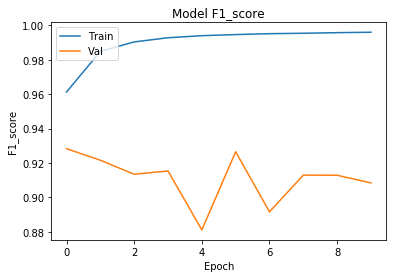

In [18]:
# Plot training & validation mean_iou values
plt.plot(results.history['f1_score'])
plt.plot(results.history['val_f1_score'])
plt.title('Model F1_score')
plt.ylabel('F1_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('F1_score.png')
plt.show()

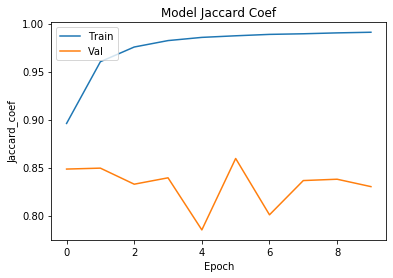

In [19]:
# Plot training & validation mean_iou values
plt.plot(results.history['jaccard_coef'])
plt.plot(results.history['val_jaccard_coef'])
plt.title('Model Jaccard Coef')
plt.ylabel('Jaccard_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('Jaccard_coef.png')
plt.show()

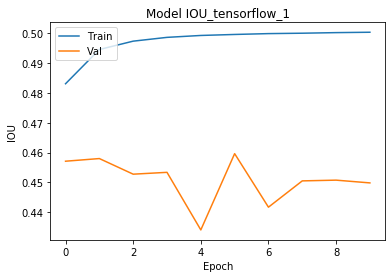

In [20]:
# Plot training & validation mean_iou values
plt.plot(results.history['Mean_IOU_tensorflow_1'])
plt.plot(results.history['val_Mean_IOU_tensorflow_1'])
plt.title('Model IOU_tensorflow_1')
plt.ylabel('IOU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('Model_IOU_tensorflow_1.png')
plt.show()

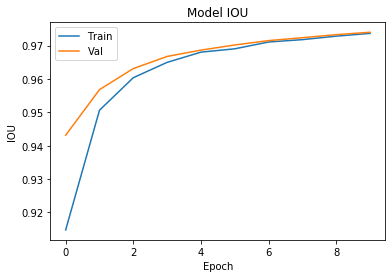

In [21]:
# Plot training & validation mean_iou values
plt.plot(results.history['mean_iou'])
plt.plot(results.history['val_mean_iou'])
plt.title('Model IOU')
plt.ylabel('IOU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('Model_IOU.png')
plt.show()

## Plot prediction

In [44]:
def plot_data_prediction1(data,cmaps,label_names=None):
    data_shape = np.array(data).shape
    numImageTypes = data_shape[0]
    numImageSets = data_shape[1]
    print(numImageTypes,numImageSets)
    fig = plt.figure(figsize=(3*numImageTypes,3*numImageSets))
    for i in range(numImageSets):
        for j in range(numImageTypes):
            ax = plt.subplot(numImageSets, numImageTypes,i*numImageTypes + j+1)
            if not label_names==None:
                ax.set_title(label_names[j])
            plt.axis('off')
            img = plt.imshow(data[j][i])
            img.set_cmap(cmaps[j])
    plt.savefig('prediction_display1.png')
    plt.show()
    
    
def plot_data_prediction2(data,cmaps,label_names=None):
    data_shape = np.array(data).shape
    numImageTypes = data_shape[0]
    numImageSets = data_shape[1]
    print(numImageTypes,numImageSets)
    fig = plt.figure(figsize=(3*numImageTypes,3*numImageSets))
    for i in range(numImageSets):
        for j in range(numImageTypes):
            ax = plt.subplot(numImageSets, numImageTypes,i*numImageTypes + j+1)
            if not label_names==None:
                ax.set_title(label_names[j])
            plt.axis('off')
            img = plt.imshow(data[j][i])
            img.set_cmap(cmaps[j])
    plt.savefig('prediction_display2.png')
    plt.show()

## Save Ground truth and prediction  as npy

In [50]:
import pickle
import os

def one_hot_decoding_max(encodings,labels): #choose class with highest probability
    decoded = []
    labels_with_bg = [0] + labels
    for img in encodings:
        if (len(img.shape)!=3):
            print("ERROR: wrong shape")
        original_shape = (img.shape[0],img.shape[1])
        img2 = np.argmax(img,axis=2)
        img3 = numpy.zeros_like(img2)
        for i,label in enumerate(labels_with_bg):
            img3 = np.where(img2==i, label, img3)
        decoded.append(img3)
    return decoded


In [51]:
test_ys_undec = one_hot_decoding_max(test_ys,labels_to_keep)  # prediction
test_y_undec  = one_hot_decoding(test_y,labels_to_keep)       # ground truth

In [52]:
#predictions = model.predict(np.array(test_x).astype(float))
predictions = test_ys_undec
groundtruths = test_y_undec
input_tests   = test_x
print('Total number of predictions: ' +str(len(test_ys_undec)))
print('Total number of ground truth: ' +str(len(test_y_undec)))
print('Total number of input scans test files: ' +str(len(test_x)))

Total number of predictions: 10
Total number of ground truth: 10
Total number of input scans test files: 10


In [53]:
# extract predictions and ground truth 

# 
pred_to_save  = []
gt_to_save    = []
input_to_save = []

#

for i, pred in enumerate(predictions):
    pred_to_save.append(pred)
    
for j, gt in enumerate(groundtruths):
    gt_to_save.append(gt)
    
for k, test in enumerate(input_tests):
    input_to_save.append(test)
    
    
# saving path
path = '../models/base_model/'
    
# save predictions with pickle to model directory
pred_file = os.path.join(path, 'preds.npy')
pickle.dump(pred_to_save, open(pred_file,"wb"))

# save ground truth with pickle to model directory
gt_file = os.path.join(path, 'gts.npy')
pickle.dump(gt_to_save, open(gt_file, "wb"))

# save inputs with pickle to model directory
input_file = os.path.join(path, 'inputs.npy')
pickle.dump(input_to_save, open(input_file, "wb"))


## Prediction results

6 10


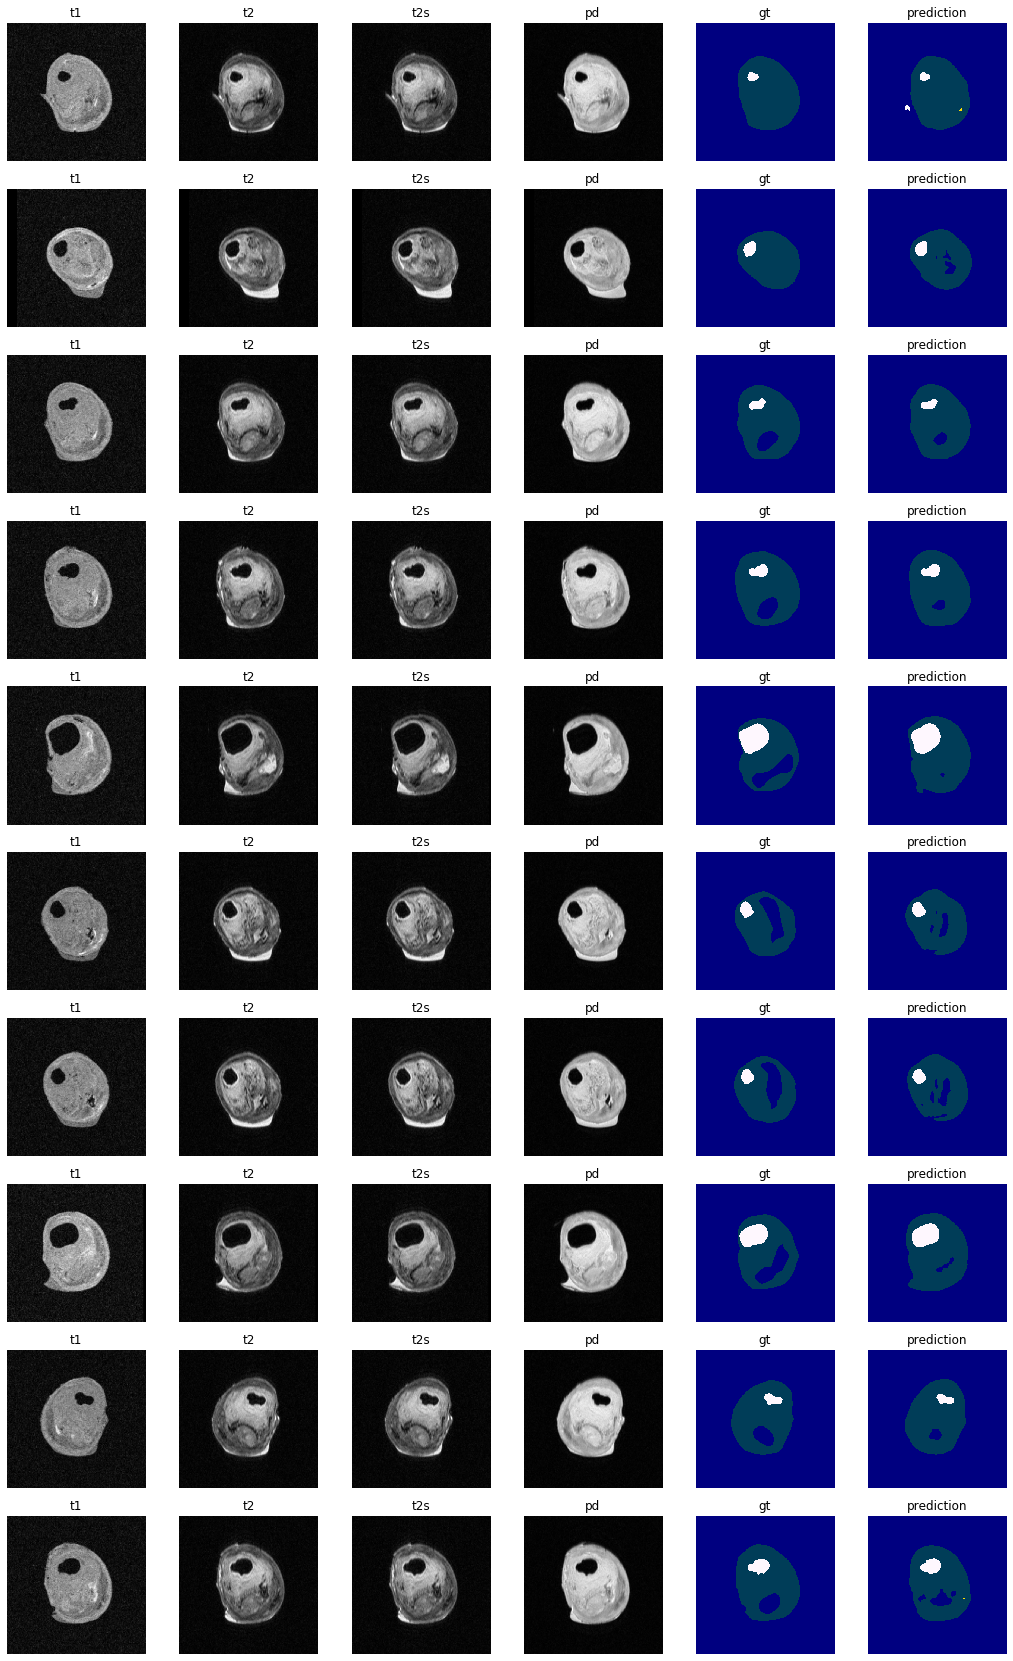

labels_with_bg: [0, 1, 2, 5, 8, 13, 14]
test_ys_labels: ['background', 'intima', 'media', 'atheromatous+hemorrhage', 'unknown', 'calcification', 'lumen']
7 10


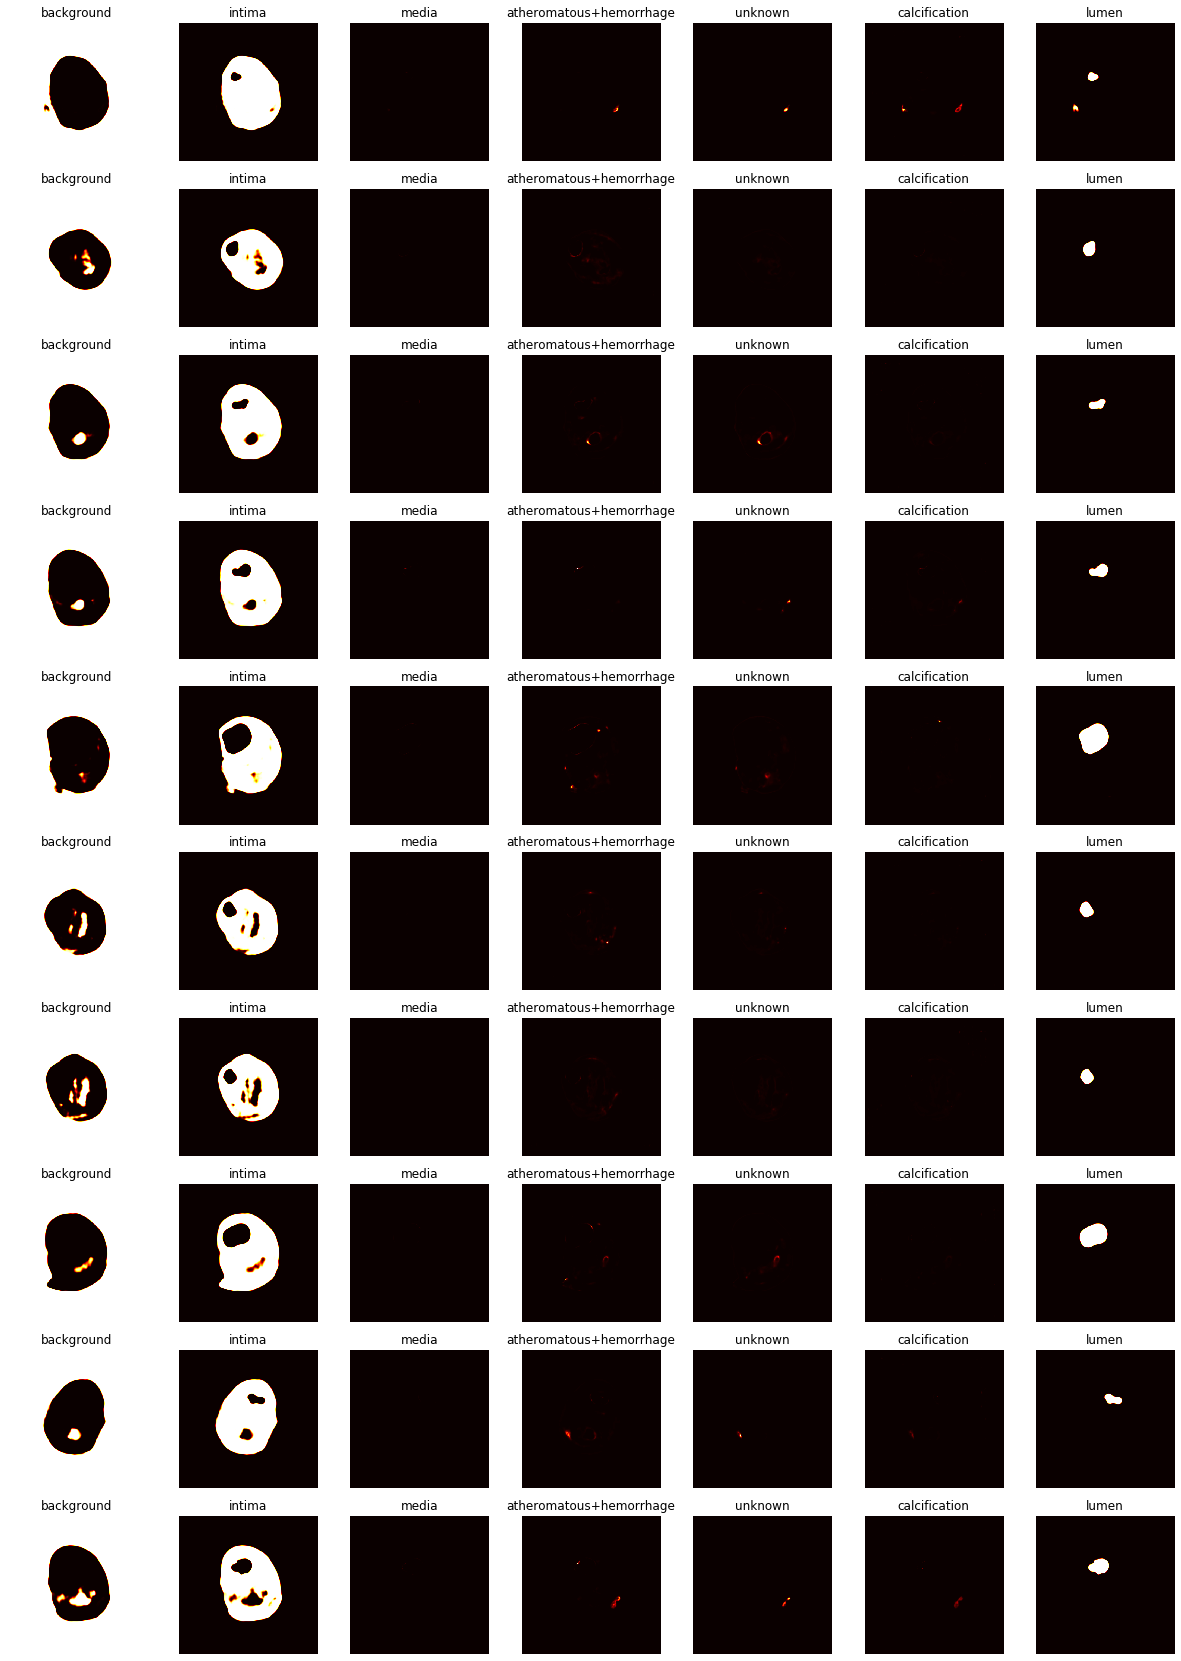

In [49]:
test_ys = model.predict(np.array(test_x).astype(float))

def one_hot_decoding_max(encodings,labels): #choose class with highest probability
    decoded = []
    labels_with_bg = [0] + labels
    for img in encodings:
        if (len(img.shape)!=3):
            print("ERROR: wrong shape")
        original_shape = (img.shape[0],img.shape[1])
        img2 = np.argmax(img,axis=2)
        img3 = numpy.zeros_like(img2)
        for i,label in enumerate(labels_with_bg):
            img3 = np.where(img2==i, label, img3)
        decoded.append(img3)
    return decoded


test_ys_undec = one_hot_decoding_max(test_ys,labels_to_keep) #prediction
test_y_undec = one_hot_decoding(test_y,labels_to_keep) #gt

plot_data_prediction1([test_x[:,:,:,0],test_x[:,:,:,1],test_x[:,:,:,2],test_x[:,:,:,3],test_y_undec,test_ys_undec],['gray','gray','gray','gray','gist_ncar','gist_ncar'],label_names=["t1","t2","t2s","pd","gt","prediction"])

labels_with_bg = [0] + labels_to_keep

print("labels_with_bg: " +str(labels_with_bg))
test_ys_list = [test_ys[:,:,:,i] for i in range(len(labels_with_bg))]
test_ys_labels = [id_to_label[l] for l in labels_with_bg]

print("test_ys_labels: " +str(test_ys_labels))
colour_maps = ['hot' for i in range(len(labels_with_bg))]
plot_data_prediction2(test_ys_list,colour_maps,label_names=test_ys_labels)

#plot_data([test_ys[:,:,:,0],test_ys[:,:,:,1],test_ys[:,:,:,2],test_ys[:,:,:,3],test_ys[:,:,:,4],test_ys[:,:,:,5]],['hot','hot','hot','hot','hot','hot'],label_names=["bg","intima","atheromatous","hem","calc","lumen"])
#print(test_ys_undec[0].shape)